# LangGraph를 이용한 Corrective RAG


## Vanilla RAG의 구조
- Query 입력 → Retriever가 문서 검색 → LLM이 문서+질문을 기반으로 답변 생성
- 매우 직관적이고 간단한 파이프라인이라 초기에 많이 쓰였음.

### Vanilla RAG의 단점

1. 검색 오류 전파 (Garbage In → Garbage Out)
    > Retriever가 관련 없는 문서를 가져오면, → LLM이 그것을 사실처럼 써버림 → 잘못된 답변(hallucination) 발생

2. 관련 없는 문서 포함 → 답변 품질 저하
    - Retrieval에서 top-k 문서를 무조건 넘기기 때문에
    - 질문과 무관한 문서도 context에 들어감
    - LLM이 혼란을 느끼거나 엉뚱한 출처를 인용할 수 있음

3. Retriever 신뢰성 부족
    - 벡터 검색(semantic search)은 항상 정확하지 않음
    - 오타, 다의어, 추상적 개념 → 검색 실패 가능

4. 비효율성
    - Retriever가 항상 문서를 가져오도록 설계되어 있음
    - 질문이 아주 단순한 경우에도 불필요하게 retrieval이 발생 → 비용 증가

5. 출처 신뢰성 문제
    - LLM은 retrieval 결과를 무조건 신뢰하는 경향이 있어
    - 출처가 부정확하거나 잘못된 정보를 포함해도 검증 없이 사용

## Corrective RAG (CRAG)
핵심 아이디어: 잘못된 retrieval 결과(irrelevant docs)를 그대로 쓰지 않고, LLM이 retrieval quality를 판단하고 수정한다.

### 구조
1. Retriever가 문서를 가져옴
2. LLM(or 별도 classifier)이 해당 문서가 질문과 관련 있는지 판단 (irrelevant이면 버림)
3. 필요시 다시 검색하거나, LLM이 자체 knowledge 기반으로 보완

### 장단점
- 장점
    - 잘못된 검색(garbage in → garbage out) 문제를 줄임
    - 쓸데없는 문서를 줄여 hallucination 위험 감소
- 단점
    - 분류 단계를 거쳐서 latency 증가 가능
    - retriever와 LLM 사이의 "판단 기준" 튜닝 필요- 

## 환경 설정 및 라이브러리 준비

LangGraph와 Chroma DB를 활용한 Corrective RAG를 구현하기 위한 환경을 설정하겠습니다.


In [1]:
# %pip install langchain==0.3.26 langchain-community==0.3.27 langchain-openai==0.3.8 langgraph==0.2.61 chromadb==1.1.0 tavily-python


In [2]:
import warnings
warnings.filterwarnings("ignore")

### API 키 설정
- [OpenAI API 키](https://platform.openai.com/api-keys)
- [Tavily API 키](https://tavily.com/) - 웹 검색용

In [ ]:
import os

# API 키 설정
os.environ["OPENAI_API_KEY"] = "sk-your-openai-api-key"

# Tavily API 키 설정 (웹 검색용)
# https://tavily.com/ 에서 무료 API 키를 받을 수 있습니다.
os.environ["TAVILY_API_KEY"] = "tvly-dev-your-tavily-api-key"

# API 키 확인
openai_key = os.getenv("OPENAI_API_KEY")
tavily_key = os.getenv("TAVILY_API_KEY")

if openai_key:
    print("OpenAI API 키가 설정되었습니다. (GPT 모델 사용)")
else:
    print("OpenAI API 키가 없습니다.")

if tavily_key:
    print("Tavily API 키가 설정되었습니다. (웹 검색 사용)")
else:
    print("Tavily API 키가 설정되지 않았습니다. 웹 검색 기능이 제한될 수 있습니다.")
    print("   https://tavily.com/ 에서 무료 API 키를 받아 설정해주세요.")

OpenAI API 키가 설정되었습니다. (GPT 모델 사용)
Tavily API 키가 설정되었습니다. (웹 검색 사용)


## Vector DB 구현

### Loader

In [4]:
from langchain_community.document_loaders import TextLoader

DATA_PATH = "./data/"
loader = TextLoader(DATA_PATH+"rag-keywords.txt")

docs = loader.load()
len(docs)

1

### Splitter

In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=600, chunk_overlap=60, length_function=len)

split_doc1 = text_splitter.split_documents(docs)
len(split_doc1)

11

### Embeddings

In [6]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

### Vector DB

In [7]:
from langchain_community.vectorstores import Chroma

vectorstore = Chroma.from_documents(
    documents=split_doc1, # 문서 리스트
    embedding=embeddings, # 임베딩 함수
    collection_name="rag_keywords", # 컬렉션 이름
    persist_directory="./chroma_rag_keywords" # 영구 저장 경로
)

print("파일이 Chroma VectorStore에 저장되었습니다.")

파일이 Chroma VectorStore에 저장되었습니다.


## Corrective RAG 워크플로우 노드 구현

### LangGraph 상태 정의

In [8]:
from typing_extensions import TypedDict, Annotated
from typing import List, Dict, Any
from langchain.schema import Document
from langgraph.graph.message import add_messages

class GraphState(TypedDict):
    """
    LangGraph에서 노드 간에 전달되는 상태를 정의합니다.
    각 노드는 이 상태를 읽고 수정할 수 있습니다.
    """
    # 사용자 입력
    question: str
    question_of_llm: str # LLM을 이용한 질문 재작성
    
    # 검색 관련
    documents: List[Document]
    search_strategy: str  # "vector", "web"
    sources: List[Dict[str, Any]]  # 출처 정보를 명확하게 관리
    
    # 평가 관련
    evaluation_result: str  # "yes", "no"
    evaluation_score: float
    evaluation_detail: str
    
    # 답변 관련
    answer: str
    generation_strategy: str
    
    # 메타데이터
    messages: Annotated[list, add_messages]



### 노드 1: 벡터 검색

In [9]:
def vector_search_node(state: GraphState) -> GraphState:
    """
    벡터 데이터베이스에서 관련 문서를 검색합니다.
    """
    print(f"벡터 검색 노드 실행: '{state['question']}'")
    
    # Chroma DB에서 유사 문서 검색
    documents = vectorstore.similarity_search(state["question"], k=5)
    
    # 출처 정보 수집
    sources = []
    for i, doc in enumerate(documents):
        source_info = {
            "type": "vector_db",
            "source": doc.metadata.get("source", f"문서_{i+1}"),
            "rank": i + 1,
            "content_preview": doc.page_content[:100] + "..." if len(doc.page_content) > 100 else doc.page_content,
            "metadata": doc.metadata
        }
        sources.append(source_info)
    
    # 상태 업데이트
    state["documents"] = documents
    state["search_strategy"] = "vector"
    state["sources"] = sources
    state["messages"].append(f"벡터 검색 완료: {len(documents)}개 문서 발견")
    
    return state


### 노드 2: 검색 품질 평가

In [10]:
import re
import json
from langchain_openai import ChatOpenAI
from langchain.prompts import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate
)

# LLM 초기화
def get_llm():
    return ChatOpenAI(
        model="gpt-5-nano"
    )

# JSON 안전 파싱
def parse_llm_json(raw_output: str):
    try:
        json_match = re.search(r"\{[\s\S]*\}", raw_output)
        if not json_match:
            raise ValueError("JSON 객체를 찾을 수 없음")

        json_str = json_match.group(0)
        return json.loads(json_str)
    except Exception as e:
        raise ValueError(f"LLM JSON 파싱 실패: {e}\n원본 응답: {raw_output}")

# 프롬프트 템플릿
def get_prompt_template_of_evaluation():
    system_template = """
        너는 검색 품질 평가를 수행하는 AI 심사위원입니다.
        검색된 문서와 질문을 읽고 관련성을 평가하세요.

        **중요 규칙**
        1. 반드시 아래 JSON 형식으로만 출력하세요.
        2. JSON 외의 다른 설명, 문장, 마크다운(````json`) 등은 출력하지 마세요.
        3. JSON은 반드시 중괄호 `{{}}` 로 감싸야 합니다.

        출력 예시:
        {{
            "evaluation_score": 0.75,
            "evaluation_result": "yes",
            "evaluation_detail": "문서들이 질문과 매우 밀접하게 관련되어 있습니다."
        }}
    """


    human_template = """
    [질문]
    {question}

    [검색된 문서]
    {context}
    """

    return ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ])

# 평가 노드
def evaluate_search_quality_node(state: dict) -> dict:
    print("LLM 기반 검색 품질 평가 노드 실행")

    question = state.get("question", "")
    documents = state.get("documents", [])

    if not isinstance(documents, list):
        raise TypeError(f"'documents'는 리스트여야 합니다. 현재 타입: {type(documents)}")

    # 문서가 없으면 no로 바로 처리
    if not documents:
        state["evaluation_result"] = "no"
        state["evaluation_score"] = 0.0
        state["evaluation_detail"] = "검색된 문서가 없습니다."
        state.setdefault("messages", []).append("평가 결과: 문서 없음 (no)")
        return state

    # 문서 내용 결합
    context_text = "\n\n".join(
        [f"[문서 {i+1}]\n{doc.page_content}" for i, doc in enumerate(documents)]
    )

    # 프롬프트 생성
    prompt = get_prompt_template_of_evaluation().format_messages(
        question=question,
        context=context_text
    )

    # LLM 호출
    response = get_llm().invoke(prompt)

    # content 안전 접근
    raw_output = getattr(response, "content", str(response)).strip()

    # JSON 파싱
    try:
        result_json = parse_llm_json(raw_output)
        evaluation_score = result_json.get("evaluation_score", 0.0)
        evaluation_result = result_json.get("evaluation_result", "no")
        evaluation_detail = result_json.get("evaluation_detail", "세부 평가 내용 없음")
    except Exception as e:
        evaluation_score = 0.0
        evaluation_result = "no"
        evaluation_detail = str(e)

    # 상태 업데이트
    state["evaluation_score"] = evaluation_score
    state["evaluation_result"] = evaluation_result
    state["evaluation_detail"] = evaluation_detail
    state.setdefault("messages", []).append(
        f"평가 결과: {evaluation_result} (점수: {evaluation_score:.2f})"
    )

    return state


### 노드 3: 질문 재작성

In [11]:
import json
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate
from langchain.schema import Document

# LLM 초기화
def get_llm():
    return ChatOpenAI(
        model="gpt-5-nano"
    )

def get_prompt_template_for_rewriting():
    # 프롬프트 템플릿 정의
    system_template = """
        너는 질문을 재작성을 수행하는 AI 도우미입니다.
        질문에 더 명확하고 구체적인 표현을 사용하여 재작성하세요.
        가능한 한 질문의 의도를 유지하면서도, 더 이해하기 쉽게 만드세요.
        재작성된 질문은 원래 질문과 동일한 의미를 가져야 합니다.
        재작성된 질문은 간결하고 명확해야 합니다.
        재작성된 질문은 불필요한 단어를 포함하지 않아야 합니다.
    """

    human_template = """
        [질문]
        {question}
    """

    return ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ])

def rewrite_question_node(state: dict) -> dict:
    print("LLM 기반 문서 재작성 노드 실행")

    question = state.get("question", "")

    # LLM 프롬프트 생성
    prompt = get_prompt_template_for_rewriting().format_messages(
        question=question
    )

    # LLM 호출
    response = get_llm().invoke(prompt)

    # 상태 업데이트
    state["question_of_llm"] = response.content.strip()
    state["search_strategy"] = "rewrite"
    state["messages"].append(f"재작성된 질문: {state['question_of_llm']}")

    return state



### 노드 4: 웹 검색

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults
import json

def web_search_node(state: GraphState) -> GraphState:
    """
    웹에서 추가 정보를 검색합니다. (Tavily Search 사용)
    """
    print("웹 검색 노드 실행 (Tavily Search)")
    
    search_query = state["question_of_llm"] if state.get("question_of_llm") else state["question"]
    
    # Tavily Search 초기화
    web_search = TavilySearchResults(
        max_results=5,
        search_depth="basic",  # "basic" 또는 "advanced"
        include_answer=False,
        include_raw_content=False,
        include_images=False,
		include_domains=[
			"https://www.weatheri.co.kr/", # 날씨 
			"https://kr.investing.com/equities/south-korea", # 주식
			"https://www.github.com/" # 소스코드
		]
    )

    try:
        # 웹 검색 실행
        search_results = web_search.run(search_query)
        
        # 검색 결과를 Document 형태로 변환
        web_docs = []
        sources = []
        
        # 검색 결과가 리스트인지 확인
        if not isinstance(search_results, list):
            search_results = []
            
        for i, result in enumerate(search_results):
            # 결과가 딕셔너리인지 확인
            if not isinstance(result, dict):
                continue
                
            # Tavily 결과 구조에 맞게 필드 추출
            title = result.get('title', f'웹 검색 결과 {i+1}')
            content = result.get('content', '내용 정보 없음')
            url = result.get('url', f'링크_{i+1}')
            score = result.get('score', 0.0)  # Tavily의 관련성 점수

            if score < 0.1:  # 너무 낮은 점수는 무시
                continue
            
            doc = Document(
                page_content=f"""
                    [제목] 
                    {title.strip()}

                    [내용] 
                    {content.strip()}
                """,
                metadata={
                    "source": url,
                    "search_query": search_query,
                    "rank": i + 1,
                    "type": "web_result",
                    "score": score
                }
            )
            web_docs.append(doc)
            
            # 출처 정보 수집
            source_info = {
                "type": "web_search",
                "source": url,
                "title": title.strip(),
                "rank": i + 1,
                "search_query": search_query,
                "content_preview": content.strip()[:100] + "..." if len(content.strip()) > 100 else content.strip(),
                "score": score,
                "metadata": {
                    "search_query": search_query,
                    "rank": i + 1,
                    "type": "web_result",
                    "score": score
                }
            }
            sources.append(source_info)
        
        # 상태 업데이트
        state["documents"] = web_docs
        state["search_strategy"] = "web"
        state["sources"] = sources
        state["messages"].append(f"Tavily 웹 검색 완료: {len(web_docs)}개")
        
        if len(web_docs) == 0:
            print("웹 검색 결과가 없습니다.")
            state["messages"].append("웹 검색 결과가 없습니다.")
            state["sources"] = []
            state["search_strategy"] = "web_failed"
        
    except Exception as e:
        print(f"Tavily 웹 검색 오류: {e}")
        # 오류 발생 시 빈 문서와 출처로 설정
        state["documents"] = []
        state["sources"] = []
        state["search_strategy"] = "web_failed"
        state["messages"].append(f"Tavily 웹 검색 오류: {e}")
    
    return state


### 노드 5: 답변 생성

In [13]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

# LLM 초기화
def get_llm():
    return ChatOpenAI(
        model="gpt-5-nano"
    )

def get_prompt_template_of_generation():

    # 프롬프트 템플릿 정의
    system_template = """
        너는 검색된 문서를 기반으로 답변을 작성하는 AI 어시스턴트입니다.
        문서에 없는 정보는 추측하지 말고, 반드시 제공된 문서 내용만을 사용하여 답변하세요.
        답변은 간결하고 이해하기 쉽게 작성하세요.
    """

    human_template = """
        [질문]
        {question}

        [검색된 문서]
        {context}

        [출력 형식]
        1. 질문에 대한 핵심 답변
        2. 필요한 경우 관련된 세부 정보
    """

    return ChatPromptTemplate.from_messages([
        SystemMessagePromptTemplate.from_template(system_template),
        HumanMessagePromptTemplate.from_template(human_template),
    ])

def generate_answer_node(state: dict) -> dict:
    """
    검색된 문서를 기반으로 LLM을 사용하여 최종 답변을 생성합니다.
    """
    print("LLM 기반 답변 생성 노드 실행")

    question = state.get("question", "")
    documents = state.get("documents", [])
    sources = state.get("sources", [])
    search_strategy = state.get("search_strategy", "vector")

    # 검색 실패 조건 확인
    evaluation_result = state.get("evaluation_result", "")
    
    search_failed = (
        not documents or  # 문서가 없음
        (search_strategy == "web_failed") or  # 웹 검색 실패
        (search_strategy == "web" and not sources) or  # 웹 검색 결과 없음
        (search_strategy == "rewrite" and not documents) or  # 질문 재작성 후 웹 검색으로 가야 하는데 문서가 없음
        (evaluation_result == "no" and search_strategy in ["rewrite", "web_failed"])  # 벡터 검색 평가 실패 후 웹 검색도 실패
    )

    # 모든 검색이 실패한 경우 - 알 수 없다고 답변하고 출처 생략
    if search_failed:
        answer = f"'{question}'에 대한 답변:\n\n죄송합니다. 해당 질문에 대한 정보를 찾을 수 없어 답변드릴 수 없습니다."
        state["answer"] = answer
        state["generation_strategy"] = "no_information"
        state["sources"] = []
        state.setdefault("messages", []).append("답변 생성: 검색 실패로 정보 없음")
        return state

    # 검색 성공한 경우 - 문서 기반 답변 생성 및 출처 표시
    # 상위 3개 문서만 사용
    if len(documents) > 3:
        documents = documents[:3]
        sources = sources[:3]  # 출처 정보도 동일하게 제한

    context_text = "\n\n".join(
        [f"[문서 {i+1}]\n{doc.page_content}" for i, doc in enumerate(documents)]
    )

    # 프롬프트에 변수 주입
    prompt = get_prompt_template_of_generation().format_messages(
        question=question,
        context=context_text
    )

    # LLM 호출
    response = get_llm().invoke(prompt)
    llm_answer = response.content.strip()

    # 검색 전략 설명
    strategy_info = {
        "vector": "벡터 데이터베이스 검색",
        "web": "웹 검색 결합"
    }

    # GraphState의 출처 정보를 활용하여 상세한 출처 표시 (검색 성공 시 반드시 표시)
    source_details = []
    for source in sources:
        if source["type"] == "vector_db":
            source_details.append(f"• 벡터DB: {source['source']} (순위: {source['rank']})")
        elif source["type"] == "web_search":
            score_info = f" (점수: {source.get('score', 0):.2f})" if source.get('score') else ""
            source_details.append(f"• 웹검색: {source['title']} - {source['source']} (순위: {source['rank']}){score_info}")
    
    # 최종 답변 조합 (검색 성공 시 반드시 출처 포함)
    final_answer_parts = [
        f"'{question}'에 대한 답변:\n",
        llm_answer,
        f"\n검색 전략: {strategy_info.get(search_strategy, search_strategy)}"
    ]
    
    # 검색 성공 시 반드시 출처 정보 표시
    if source_details:
        final_answer_parts.append(f"출처 정보:")
        final_answer_parts.extend(source_details)
    else:
        # 문서는 있지만 출처 정보가 없는 예외적인 경우
        final_answer_parts.append(f"출처 정보: 출처 정보를 확인할 수 없습니다.")

    final_answer = "\n".join(final_answer_parts)

    # 상태 업데이트
    state["answer"] = final_answer
    state["generation_strategy"] = search_strategy
    state.setdefault("messages", []).append(f"답변 생성 완료 (LLM 사용, {len(documents)}개 문서 기반)")

    return state


### 조건부 라우팅 함수들

In [14]:
def decide_search_strategy(state: GraphState) -> str:
    """
    평가 결과에 따라 다음 노드를 결정합니다.
    """
    evaluation_result = state["evaluation_result"]
    
    print(f"라우팅 결정: {evaluation_result}")
    
    if evaluation_result == "yes":
        return "generate_answer"
    else:
        return "rewrite_question"



## LangGraph 워크플로우 구성

이제 정의한 노드들을 연결하여 완전한 LangGraph 워크플로우를 구성해보겠습니다.


In [15]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver

# LangGraph 워크플로우 생성
def create_corrective_rag_graph():
    """
    Corrective RAG를 위한 LangGraph 워크플로우를 생성합니다.
    """
    # StateGraph 인스턴스 생성
    workflow = StateGraph(GraphState)
    
    # 노드 추가
    workflow.add_node("vector_search", vector_search_node)
    workflow.add_node("evaluate_quality", evaluate_search_quality_node)
    workflow.add_node("rewrite_question", rewrite_question_node)
    workflow.add_node("web_search", web_search_node)
    workflow.add_node("generate_answer", generate_answer_node)
    
    # 시작점 설정: 벡터 검색부터 시작
    workflow.add_edge(START, "vector_search")
    
    # 벡터 검색 → 품질 평가
    workflow.add_edge("vector_search", "evaluate_quality")
    
    # 품질 평가 → 조건부 라우팅
    workflow.add_conditional_edges(
        "evaluate_quality",
        decide_search_strategy,
        {
            "generate_answer": "generate_answer",
            "rewrite_question": "rewrite_question"
        }
    )

    # 질문 재작성 → 웹 검색
    workflow.add_edge("rewrite_question", "web_search")
    
    # 웹 검색 → 답변 생성
    workflow.add_edge("web_search", "generate_answer")
    
    # 답변 생성 → 종료
    workflow.add_edge("generate_answer", END)
    
    # 메모리 설정 (선택사항 - 대화 기록 저장용)
    memory = MemorySaver()
    
    # 그래프 컴파일
    app = workflow.compile(checkpointer=memory)
    
    print("LangGraph Corrective RAG 워크플로우가 생성되었습니다!")
    return app


In [16]:
# 워크플로우 재생성 (검색 실패 로직 수정)
corrective_rag_app = create_corrective_rag_graph()


LangGraph Corrective RAG 워크플로우가 생성되었습니다!


### Corrective RAG 그래프

```
                    시작
                     |
                     v
                    vector_search
                    (벡터 데이터베이스에서 관련 문서를 검색)
                     |
                     v
                    evaluate_quality
                    (LLM 기반 검색 품질 평가)
                     |
                     v
         +-----------+-----------+
         |                       |
         v                       |
  rewrite_question               | 
  (LLM 기반 문서 재작성)         |
         |                       |
         v                       |
  web_search                     |    
  (웹에서 추가 정보를 검색)      |
         |                       |
         +-----+-----+-----------+
                     |
                     v
                    generate_answer
                    (검색된 문서를 기반으로 LLM을 사용하여 최종 답변을 생성)
                     |
                     v
                    종료
```

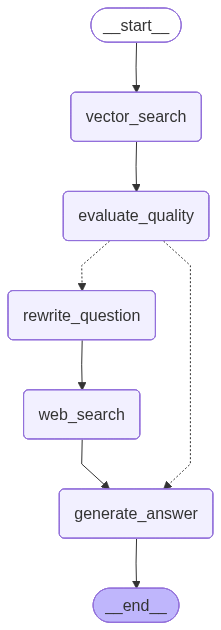

In [17]:
from IPython.display import Image, display

try:
    
    display(
        Image(
            corrective_rag_app.get_graph().draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"그래프 표시 오류: {e}")


## 실습 예제 및 테스트

이제 완성된 LangGraph Corrective RAG 시스템을 다양한 질문으로 테스트해보겠습니다.


In [18]:
# 편리한 실행 함수
def run_corrective_rag(question: str, thread_id: str = "demo_thread") -> Dict[str, Any]:
    print(f"Corrective RAG 실행 시작")
    print(f"질문: {question}")
    print("=" * 60)
    
    # 초기 상태 설정
    initial_state = {
        "question": question,
        "question_of_llm": "",
        "documents": [],
        "search_strategy": "",
        "sources": [],  # 출처 정보 초기화
        "evaluation_result": "",
        "evaluation_score": 0.0,
        "evaluation_detail": "",
        "answer": "",
        "generation_strategy": "",
        "messages": []
    }
    
    # 워크플로우 실행
    config = {"configurable": {"thread_id": thread_id}}
    
    try:
        # 스트리밍 방식으로 실행 과정 확인
        final_state = None
        for step in corrective_rag_app.stream(initial_state, config):
            # 각 단계의 실행 상황을 실시간으로 볼 수 있습니다
            step_info = list(step.keys())[0] if step else "unknown"
            print(f"현재 실행 중: {step_info}")
            final_state = list(step.values())[0] if step else final_state
        
        print("워크플로우 실행 완료!")
        print("=" * 60)
        
        return final_state
        
    except Exception as e:
        print(f"실행 중 오류 발생: {e}")
        return {"error": str(e), "question": question}

In [19]:
# 결과 출력 함수
def display_results(result: Dict[str, Any]):
    """
    실행 결과를 보기 좋게 출력합니다.
    """
    if "error" in result:
        print(f"오류: {result['error']}")
        return
    
    print(f"실행 결과 요약:")
    print("=" * 40)
    print(f"질문: {result.get('question', 'N/A')}")
    print(f"평가 결과: {result.get('evaluation_result', 'N/A')} (점수: {result.get('evaluation_score', 0):.2f})")
    print(f"검색 전략: {result.get('search_strategy', 'N/A')}")
    print(f"사용된 문서 수: {len(result.get('documents', []))}")
    print(f"출처 수: {len(result.get('sources', []))}")
    
    print(f"최종 답변:")
    print("-" * 30)
    print(result.get('answer', '답변을 생성할 수 없습니다.'))
    
    print(f"실행 로그:")
    print("-" * 20)
    for i, message in enumerate(result.get('messages', []), 1):
        print(f"{i}. {message}")


### 실습 예제 1: 높은 관련성 질문 (직접 답변 생성)

In [20]:
print("예상 경로: 벡터 검색 → 평가(yes) → 답변 생성")

result1 = run_corrective_rag("임베딩이란 무엇인가요?")
display_results(result1)


예상 경로: 벡터 검색 → 평가(yes) → 답변 생성
Corrective RAG 실행 시작
질문: 임베딩이란 무엇인가요?
벡터 검색 노드 실행: '임베딩이란 무엇인가요?'
현재 실행 중: vector_search
LLM 기반 검색 품질 평가 노드 실행
라우팅 결정: yes
현재 실행 중: evaluate_quality
LLM 기반 답변 생성 노드 실행
현재 실행 중: generate_answer
워크플로우 실행 완료!
실행 결과 요약:
질문: 임베딩이란 무엇인가요?
평가 결과: yes (점수: 0.92)
검색 전략: vector
사용된 문서 수: 5
출처 수: 5
최종 답변:
------------------------------
'임베딩이란 무엇인가요?'에 대한 답변:

1. 핵심 답변
- 임베딩은 텍스트 데이터(예: 단어나 문장)를 저차원의 연속적인 벡터로 변환하는 과정으로, 이를 통해 컴퓨터가 텍스트를 이해하고 처리할 수 있게 합니다. 예시: "사과"를 [0.65, -0.23, 0.17] 같은 벡터로 표현합니다.

2. 필요한 경우 관련된 세부 정보
- 연관 키워드: 자연어 처리, 벡터화, 딥러닝

검색 전략: 벡터 데이터베이스 검색
출처 정보:
• 벡터DB: ./data/rag-keywords.txt (순위: 1)
• 벡터DB: ./data/rag-keywords.txt (순위: 2)
• 벡터DB: ./data/rag-keywords.txt (순위: 3)
실행 로그:
--------------------
1. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='fcbf37b7-190c-450e-b3e7-8c6f51d576ff'
2. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='5cd9baff-1f28-4f30-983f-e3128faed061'
3. content='평가 결과: yes

### 실습 예제 2: 낮은 관련성 질문 (웹 검색 후 답변 생성)

In [21]:
### 웹 검색 출처 테스트

print("수정된 웹 검색 기능 테스트")
print("예상 경로: 벡터 검색 → 평가(no) → 질문 재작성 → 웹 검색 → 답변 생성")

result_web_test = run_corrective_rag("삼성전자 주가 어때?")
display_results(result_web_test)


수정된 웹 검색 기능 테스트
예상 경로: 벡터 검색 → 평가(no) → 질문 재작성 → 웹 검색 → 답변 생성
Corrective RAG 실행 시작
질문: 삼성전자 주가 어때?
벡터 검색 노드 실행: '삼성전자 주가 어때?'
현재 실행 중: vector_search
LLM 기반 검색 품질 평가 노드 실행
라우팅 결정: no
현재 실행 중: evaluate_quality
LLM 기반 문서 재작성 노드 실행
현재 실행 중: rewrite_question
웹 검색 노드 실행 (Tavily Search)


/var/folders/tv/05qbcb8954z9x1yvqv_kr2t80000gn/T/ipykernel_46637/58809085.py:13: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  web_search = TavilySearchResults(


현재 실행 중: web_search
LLM 기반 답변 생성 노드 실행
현재 실행 중: generate_answer
워크플로우 실행 완료!
실행 결과 요약:
질문: 삼성전자 주가 어때?
평가 결과: no (점수: 0.05)
검색 전략: web
사용된 문서 수: 2
출처 수: 2
최종 답변:
------------------------------
'삼성전자 주가 어때?'에 대한 답변:

1. 핵심 답변
- 제공된 문서에는 삼성전자 주가의 현재 가격 정보가 포함되어 있지 않아 답변해 드릴 수 없습니다.

2. 필요한 경우 관련된 세부 정보
- 문서 1: 삼성전자의 목표주가를 묻는 예시가 있지만 구체적인 수치나 최신 가격은 제시되지 않습니다.
- 문서 2: 시장가 주문의 동작 원리 등 주식 거래에 대한 일반 설명이 담겨 있지만 주가 정보는 포함되어 있지 않습니다.

검색 전략: 웹 검색 결합
출처 정보:
• 웹검색: hngyb/Finance-QA: 금융어: 한국어 사전 학습 언어 모델 ... - https://github.com/hngyb/Finance-QA (순위: 1) (점수: 0.34)
• 웹검색: 주식 공부 - https://gist.github.com/Curookie/acad8f83e8c456986808c9eb08c9036d (순위: 2) (점수: 0.15)
실행 로그:
--------------------
1. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='fcbf37b7-190c-450e-b3e7-8c6f51d576ff'
2. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='5cd9baff-1f28-4f30-983f-e3128faed061'
3. content='평가 결과: yes (점수: 0.92)' additional_kwargs={} response_metadata={} id='

### 실습 예제 3: 검색 실패 시 처리 테스트 

In [22]:
### 검색 실패 시 처리 테스트 (수정된 로직)

print("검색 실패 시 '알 수 없다' 답변 및 출처 생략 테스트")
print("예상: 벡터 검색 → 평가(no) → 질문 재작성 → 웹 검색 실패 → '알 수 없다' 답변 (출처 없음)")

result_fail_test_fixed = run_corrective_rag("화성에서 살고 있는 외계인의 일상생활")
display_results(result_fail_test_fixed)


검색 실패 시 '알 수 없다' 답변 및 출처 생략 테스트
예상: 벡터 검색 → 평가(no) → 질문 재작성 → 웹 검색 실패 → '알 수 없다' 답변 (출처 없음)
Corrective RAG 실행 시작
질문: 화성에서 살고 있는 외계인의 일상생활
벡터 검색 노드 실행: '화성에서 살고 있는 외계인의 일상생활'
현재 실행 중: vector_search
LLM 기반 검색 품질 평가 노드 실행
라우팅 결정: no
현재 실행 중: evaluate_quality
LLM 기반 문서 재작성 노드 실행
현재 실행 중: rewrite_question
웹 검색 노드 실행 (Tavily Search)
웹 검색 결과가 없습니다.
현재 실행 중: web_search
LLM 기반 답변 생성 노드 실행
현재 실행 중: generate_answer
워크플로우 실행 완료!
실행 결과 요약:
질문: 화성에서 살고 있는 외계인의 일상생활
평가 결과: no (점수: 0.00)
검색 전략: web_failed
사용된 문서 수: 0
출처 수: 0
최종 답변:
------------------------------
'화성에서 살고 있는 외계인의 일상생활'에 대한 답변:

죄송합니다. 해당 질문에 대한 정보를 찾을 수 없어 답변드릴 수 없습니다.
실행 로그:
--------------------
1. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='fcbf37b7-190c-450e-b3e7-8c6f51d576ff'
2. content='벡터 검색 완료: 5개 문서 발견' additional_kwargs={} response_metadata={} id='5cd9baff-1f28-4f30-983f-e3128faed061'
3. content='평가 결과: yes (점수: 0.92)' additional_kwargs={} response_metadata={} id='873f1584-910e-40df-a3a9-aa482dc9